## Packages

In [116]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [145]:
def plot_fai_analysis_summary(df_anticipation_time, n_days, window_minutes,
                             fai_metric="FAIalerts_StartPeak",  # Puedes cambiar por otras columnas
                             group_subclasses=False,
                             color_mode="palette:viridis"):
    """
    Versión especializada para análisis FAI con diferentes métricas disponibles.
    
    Métricas FAI disponibles:
    - "FAIalerts_W": Alertas en ventana completa
    - "FAIalerts_WStart": Alertas desde ventana start
    - "FAIalerts_StartPeak": Alertas entre start y peak
    - "FAIalerts_PeakEnd": Alertas entre peak y end
    - "AnticipationStart": Tiempo de anticipación desde start
    - "AnticipationPeak": Tiempo de anticipación desde peak
    """
    
    df = df_anticipation_time.copy()
    
    # Verificar que la métrica existe
    if fai_metric not in df.columns:
        available_metrics = [col for col in df.columns if 'FAI' in col or 'Anticipation' in col]
        raise ValueError(f"Métrica '{fai_metric}' no encontrada. Disponibles: {available_metrics}")
    
    print(f"Usando métrica FAI: {fai_metric}")
    
    # Determinar si es booleano (conteo) o numérico (tiempo)
    if 'Anticipation' in fai_metric:
        # Es una métrica de tiempo - calcular % con anticipación > 0
        df['FAI_bool'] = df[fai_metric] > 0
        metric_type = "Tiempo de anticipación"
    else:
        # Es una métrica de conteo - calcular % con al menos 1 alerta
        df['FAI_bool'] = df[fai_metric] > 0
        metric_type = "Alertas FAI"
    
    # Agrupación de clases (igual que antes)
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }
    
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}-" + (f"{high}" if high < 1000 else "+")
        return flare_class

    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(lambda x: assign_flare_group(str(x)))
    else:
        df["ClassGroup"] = df["Class"].astype(str)

    # Cálculos
    group_col = "ClassGroup"
    flare_summary = (df.groupby(group_col)['FAI_bool'].mean() * 100).reset_index()
    flare_summary.rename(columns={'FAI_bool': "FAI_percent"}, inplace=True)
    flare_counts = df.groupby(group_col)['FAI_bool'].count()

    classes = flare_summary[group_col].tolist()
    values = flare_summary["FAI_percent"].tolist()
    n_bars = len(classes)

    # Configuración de colores 
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        try:
            # Para matplotlib >= 3.7
            cmap = plt.colormaps[cmap_name].resampled(n_bars)
        except (AttributeError, KeyError):
            # Para versiones anteriores
            cmap = plt.cm.get_cmap(cmap_name, n_bars)
        
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # Plot
    chart_width = max(10, n_bars * 1.3)
    chart_height = 7

    fig, (ax, ax_leg) = plt.subplots(2, 1, figsize=(chart_width, chart_height), 
                                    gridspec_kw={'height_ratios': [3, 1]})

    # Barras principales
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9,  alpha=0.9, edgecolor='black', linewidth=1.2)
    ax.set_xlim(-0.7, n_bars - 0.3)
    ax.set_ylim(0, 100)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=0, ha="center", fontsize=12)
    ax.set_ylabel("FAI Detection Rate (%)")
    ax.set_xlabel("Flare Class")
    ax.set_title(f"FAI Detection by Flare Class\n({fai_metric}, {n_days} days, {window_minutes} min window)")
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.3)

    # Etiquetas encima de las barras - SOLO porcentajes
    for i, (bar, value) in enumerate(zip(bars, values)):
        if value > 0:  # Solo mostrar etiqueta si hay valor
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=11, fontweight='bold')

    
    

    # Leyenda
    ax_leg.axis("off")
    legend_labels = [f"{cls} (n={flare_counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=10, linestyle="",
                          color=colors[i], label=legend_labels[i]) for i in range(n_bars)]
    
    ncol = min(n_bars, 4)
    ax_leg.legend(handles=handles, loc="center", ncol=ncol, frameon=False,
                  title=f"Flare counts (Total: {len(df)})")

    
    # Guardar
    output_name = f"FAI_Analysis_{fai_metric}_{n_days}d_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")

    # Estadísticas
    total = len(df)
    with_fai = df['FAI_bool'].sum()
    print(f"\n--- Resumen {fai_metric} ---")
    print(f"Total flares: {total}")
    print(f"Flares con FAI: {with_fai} ({with_fai/total*100:.1f}%)")
    print(f"Métrica: {metric_type}")

def plot_anticipation_time_summary(df_anticipation_time, n_days, window_minutes):
    """
    Gráfica especializada para tiempos de anticipación FAI.
    """
    df = df_anticipation_time.copy()
    
    # Columnas de tiempo de anticipación
    time_columns = [col for col in df.columns if 'Anticipation' in col or 'Time_since' in col]
    time_columns = [col for col in time_columns if df[col].dtype in ['float64', 'int64']]
    
    if not time_columns:
        print("No se encontraron columnas de tiempo de anticipación numéricas")
        return
    
    n_metrics = len(time_columns)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    
    if n_metrics == 1:
        axes = [axes]
    
    for i, time_col in enumerate(time_columns):
        ax = axes[i]
        
        # Filtrar valores válidos
        valid_times = df[time_col].dropna()
        
        if len(valid_times) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{time_col}\n(No data)")
            continue
        
        # Crear histograma
        ax.hist(valid_times, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        
        ax.set_xlabel("Time (minutes)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{time_col}\n(n={len(valid_times)})")
        
        # Estadísticas en el gráfico
        stats_text = f"Mean: {valid_times.mean():.1f} min\nMedian: {valid_times.median():.1f} min\nMax: {valid_times.max():.1f} min"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                ha='right', va='top', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.suptitle(f"FAI Anticipation Time Distribution ({n_days} days, Window = {window_minutes} min)", 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_Anticipation_Time_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")

def plot_fai_association(df_anticipation_time, n_days, window_minutes, fai_column="FAIalerts_W"):
    """
    Genera una gráfica de barras mostrando cuántos flares tienen FAIs asociados.
    Con porcentaje dentro de la barra y número total encima.
    
    Parámetros:
    - df_anticipation_time: DataFrame con datos de anticipación FAI
    - n_days: número de días (para título)
    - window_minutes: ventana de tiempo (para título)
    - fai_column: nombre de la columna que indica si hay FAI asociado
    """
    df = df_anticipation_time.copy()
    window=fai_column
    # Verificar que la columna FAI existe
    if fai_column not in df.columns:
        available_columns = [col for col in df.columns if 'FAI' in col]
        raise ValueError(f"Columna '{fai_column}' no encontrada. Columnas disponibles con FAI: {available_columns}")
    
    print(f"Usando columna FAI: {fai_column}")
    
    # Convertir a booleano (si es numérica)
    if df[fai_column].dtype in ['int64', 'float64']:
        df['FAI_bool'] = df[fai_column] > 0
    else:
        df['FAI_bool'] = df[fai_column].astype(bool)

    # Contar cuántos flares tienen FAI y cuántos no
    counts = df['FAI_bool'].value_counts()
    total = counts.sum()
    
    # Reordenar para que True = With FAI aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)
    
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14
    })

    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['With FAI', 'Without FAI'])
    ax.set_ylabel("Percentage of Flares (%)")
    ax.set_title(f"Flares with Associated FAIs ({n_days} days, Window = {window_minutes} min, {window})",
                 pad=20)
    
    # Agregar porcentaje dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')
    
    # Agregar número total arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")
    
    # Leyenda con total de flares en esquina superior derecha
    ax.text(0.95, 0.95, f"Total Flares = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    flares_with_fai = counts.get(True, 0)
    flares_without_fai = counts.get(False, 0)
    
    print(f"\n--- Estadísticas FAI ---")
    print(f"Total flares analizados: {total}")
    print(f"Flares con FAI: {flares_with_fai} ({percentages.get(True, 0):.1f}%)")
    print(f"Flares sin FAI: {flares_without_fai} ({percentages.get(False, 0):.1f}%)")
    print(f"Columna FAI utilizada: {fai_column}")

def plot_fai_association_compact_grid(df_anticipation_time, n_days, window_minutes):
    """
    Versión compacta con gráficas más pequeñas para muchas métricas.
    """
    df = df_anticipation_time.copy()
    
    # Identificar todas las columnas FAI disponibles
    fai_columns = [col for col in df.columns if 'FAI' in col and 'Unnamed' not in col]
    
    if not fai_columns:
        raise ValueError("No se encontraron columnas FAI en el dataframe")
    
    print(f"Columnas FAI encontradas: {fai_columns}")
    
    n_metrics = len(fai_columns)
    n_cols = 2
    n_rows = (n_metrics + 1) // 2
    
    # Tamaños más compactos para muchas métricas
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    
    # Manejar diferentes casos de dimensiones
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    plt.rcParams.update({
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    })
    
    metric_count = 0
    
    for i in range(n_rows):
        for j in range(n_cols):
            if metric_count < n_metrics:
                fai_column = fai_columns[metric_count]
                ax = axes[i, j]
                
                # Convertir a booleano
                if df[fai_column].dtype in ['int64', 'float64']:
                    fai_bool = df[fai_column] > 0
                else:
                    fai_bool = df[fai_column].astype(bool)
                
                counts = fai_bool.value_counts().reindex([True, False])
                total = len(df)
                percentages = (counts / total * 100).round(1)
                
                bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'], alpha=0.8)
                
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['With\nFAI', 'No\nFAI'], fontsize=8)
                ax.set_ylabel("Percentage (%)", fontsize=9)
                ax.set_title(f"{fai_column}", fontsize=10, pad=5)
                ax.set_ylim(0, 100)
                ax.grid(True, alpha=0.3, axis='y')
                
                # Porcentajes dentro de las barras
                for bar, pct in zip(bars, percentages):
                    if pd.notna(pct):
                        ax.text(bar.get_x() + bar.get_width()/2,
                                bar.get_height()/2,
                                f"{pct:.1f}%",
                                ha='center', va='center', 
                                fontsize=8, color="black", fontweight='bold')
                
                # Conteos arriba de las barras
                for bar, count in zip(bars, counts):
                    if pd.notna(count):
                        ax.text(bar.get_x() + bar.get_width()/2,
                                bar.get_height() + 1,
                                f"n={int(count)}",
                                ha='center', va='bottom', 
                                fontsize=7, color="black")
                
                metric_count += 1
            else:
                # Ocultar ejes sobrantes
                axes[i, j].axis('off')
    
    plt.suptitle(f"FAI Association Analysis - {n_days} days (Window: {window_minutes} min)", 
                 fontsize=14, y=1.01)
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_Compact_Grid_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")

def plot_fai_association_summary(df_fai_assoc, n_days, window_minutes, column="Associated_Flare"):
    """
    Genera un gráfico de barras mostrando el porcentaje de FAIs
    que están asociados con flares (True) y no asociados (False).

    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare').
    n_days : int
        Número de días analizados (para título).
    window_minutes : int
        Ventana de tiempo en minutos usada para definir asociación.
    column : str, default="Associated_Flare"
        Nombre de la columna con valores True/False.
    """
    # Usar el dataframe directamente
    df_fai = df_fai_assoc.copy()

    # Verificar que la columna existe
    if column not in df_fai.columns:
        available_columns = df_fai.columns.tolist()
        raise ValueError(f"Columna '{column}' no encontrada. Columnas disponibles: {available_columns}")

    # Contar True (asociados) vs False (no asociados)
    counts = df_fai[column].value_counts()
    total = counts.sum()

    # Reordenar para que True = Asociados aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)

    # Configuración del plot
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'], alpha=0.8)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Associated', 'Not Associated'])
    ax.set_ylabel("Percentage of FAIs (%)")
    ax.set_title(f"FAI Alerts Associated with Flares\n({n_days} days, Window = {window_minutes} min)",
                 pad=20)

    # Añadir porcentajes dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')

    # Añadir conteos absolutos arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 1,
                    f"n={int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")

    # Recuadro con total de alertas FAI dentro del gráfico
    ax.text(0.95, 0.95, f"Total FAI Alerts = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=11,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_FAI_associated_Flares_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    associated_count = counts.get(True, 0)
    not_associated_count = counts.get(False, 0)
    
    print(f"\n--- Estadísticas de Asociación FAI-Flare ---")
    print(f"Total alertas FAI analizadas: {total}")
    print(f"FAIs asociados a flares: {associated_count} ({percentages.get(True, 0):.1f}%)")
    print(f"FAIs no asociados: {not_associated_count} ({percentages.get(False, 0):.1f}%)")
    print(f"Ventana de asociación: {window_minutes} minutos")

def plot_fai_distribution(df_fai_assoc, n_days, window_minutes,
                         class_col="F_Class",
                         assoc_col="Associated_Flare",
                         group_subclasses=False,
                         color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages:
    - Fraction of FAIs associated with each flare class (or subrange if group_subclasses=True)
    - Fraction not associated with any flare ("No flare")
    
    Parameters:
    - df_fai_assoc: DataFrame with at least columns `class_col` and `assoc_col`
    - n_days: number of days analyzed (for title)
    - window_minutes: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = df_fai_assoc.copy()

    # Verificar que las columnas necesarias existen
    if class_col not in df.columns or assoc_col not in df.columns:
        available_cols = df.columns.tolist()
        raise ValueError(f"DataFrame must contain '{class_col}' and '{assoc_col}'. Available columns: {available_cols}")

    print(f"Usando columnas: {class_col} para clases y {assoc_col} para asociación")
    print(f"Total FAIs en análisis: {len(df)}")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]

    # Etiquetar FAIs no asociados
    df["AssocGroup"] = df.apply(
        lambda row: row["ClassGroup"] if row[assoc_col] else "No flare", axis=1
    )

    # Contar distribución
    counts = df["AssocGroup"].value_counts()

    # Ordenar clases: primero A, B, C, M, X o sus subrangos, luego "No flare"
    if group_subclasses:
        flare_classes = sorted([c for c in counts.index if c != "No flare"])
    else:
        flare_classes_order = ["A", "B", "C", "M", "X"]
        flare_classes = [cls for cls in flare_classes_order if cls in counts.index]

    if "No flare" in counts.index:
        flare_classes.append("No flare")

    counts_ordered = counts[flare_classes]
    percentages = (counts_ordered / counts_ordered.sum()) * 100

    classes = percentages.index.tolist()
    values = percentages.tolist()
    n_bars = len(classes)

    print(f"Distribución encontrada: {dict(zip(classes, counts_ordered))}")

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        # Usar la nueva sintaxis para obtener colormaps
        try:
            # Para matplotlib >= 3.7
            cmap = plt.colormaps[cmap_name].resampled(n_bars)
        except (AttributeError, KeyError):
            # Para versiones anteriores
            cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato",
                       "No flare": "lightgray"}
        colors = [base_colors.get(str(c)[0], base_colors.get(c, "gray")) for c in classes]
    else:
        colors = "skyblue"

    # --- Layout con leyenda abajo ---
    chart_width = max(8, n_bars * 1.3)
    chart_height = 6.7

    fontsize = 10
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    # --- Subplots ---
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 15,
        "legend.fontsize": 14
    })

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=1.0) # espacio entre gráfico y leyenda
    
    # --- Gráfico de barras ---
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_ylim(0, max(values) * 1.1)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("FAIs (% of total)")
    ax.set_xlabel("Flare Class (or No flare)")
    ax.set_title(f"Distribution of FAIs: Associated vs Not Associated\n({n_days} days, Window = {window_minutes} min)",
                 pad=20) # espacio entre título y gráfico

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=14, fontweight='bold')

    # --- Leyenda abajo ---
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts_ordered[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title_fontsize=16, # tamaño titulo leyenda
                  title="Number of FAIs per group:")

    output_name = f"{n_days}d_Distribution_FAIs_All_Window{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    total_fais = len(df)
    associated_fais = df[assoc_col].sum()
    not_associated_fais = total_fais - associated_fais
    
    print(f"\n--- Estadísticas de Distribución FAI ---")
    print(f"Total FAIs: {total_fais}")
    print(f"FAIs asociados a flares: {associated_fais} ({associated_fais/total_fais*100:.1f}%)")
    print(f"FAIs no asociados: {not_associated_fais} ({not_associated_fais/total_fais*100:.1f}%)")
    
    if associated_fais > 0:
        print(f"\nDistribución de FAIs asociados por clase:")
        associated_by_class = df[df[assoc_col]]['ClassGroup'].value_counts()
        for cls, count in associated_by_class.items():
            percentage = (count / associated_fais) * 100
            print(f"  {cls}: {count} FAIs ({percentage:.1f}%)")

def plot_fai_distribution_by_flare_class(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                                        class_col="F_Class", assoc_col="Associated_Flare",
                                        group_subclasses=False, color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages relative to total flares in each class:
    - Percentage of flares in each class that were detected by FAI alerts
    - Shows FAI detection efficiency per flare class
    
    Parameters:
    - df_fai_assoc: DataFrame with FAI alerts and their associations
    - df_anticipation_time: DataFrame with flare information (for total flare counts)
    - n_days: number of days analyzed (for title)
    - window_minutes: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = df_fai_assoc.copy()
    df_flares = df_anticipation_time.copy()

    # Verificar que las columnas necesarias existen
    if class_col not in df.columns or assoc_col not in df.columns:
        available_cols = df.columns.tolist()
        raise ValueError(f"DataFrame must contain '{class_col}' and '{assoc_col}'. Available columns: {available_cols}")

    print(f"Using columns: {class_col} for classes and {assoc_col} for association")
    print(f"Total FAIs in analysis: {len(df)}")
    print(f"Total flares in analysis: {len(df_flares)}")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
        df_flares["ClassGroup"] = df_flares["Class"].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]
        df_flares["ClassGroup"] = df_flares["ClassLetter"].astype(str)

    # --- CORRECCIÓN: Contar flares detectados por FAI por clase ---
    # Obtener los ClassGroup de los flares que SÍ fueron detectados por FAI
    flares_with_fai = df_flares[df_flares['FAIalerts_W'] > 0]
    detected_flares_by_class = flares_with_fai["ClassGroup"].value_counts()
    
    # Contar total de flares por clase
    total_flares_by_class = df_flares["ClassGroup"].value_counts()

    # Combinar las clases de ambos DataFrames
    all_classes = sorted(set(detected_flares_by_class.index) | set(total_flares_by_class.index))
    
    # Calcular porcentajes CORRECTOS: (flares detectados / total flares) * 100
    class_stats = []
    for class_name in all_classes:
        flares_detected = detected_flares_by_class.get(class_name, 0)
        total_flares = total_flares_by_class.get(class_name, 0)
        
        if total_flares > 0:
            detection_rate = (flares_detected / total_flares) * 100
        else:
            detection_rate = 0
            
        class_stats.append({
            'Class': class_name,
            'Flares_Detected': flares_detected,
            'Total_Flares': total_flares,
            'Detection_Rate': detection_rate
        })

    # Crear DataFrame ordenado
    stats_df = pd.DataFrame(class_stats)
    
    # Ordenar clases: A, B, C, M, X (y subclases si aplica)
    if group_subclasses:
        # Ordenar subclases numéricamente
        stats_df = stats_df.sort_values('Class')
    else:
        class_order = ['A', 'B', 'C', 'M', 'X']
        stats_df['Class'] = pd.Categorical(stats_df['Class'], categories=class_order, ordered=True)
        stats_df = stats_df.sort_values('Class')

    classes = stats_df['Class'].tolist()
    values = stats_df['Detection_Rate'].tolist()
    total_flares_counts = stats_df['Total_Flares'].tolist()
    flares_detected_counts = stats_df['Flares_Detected'].tolist()
    
    n_bars = len(classes)

    print(f"\nFAI Detection Rate by Flare Class:")
    for _, row in stats_df.iterrows():
        print(f"  {row['Class']}: {row['Flares_Detected']}/{row['Total_Flares']} flares detected = {row['Detection_Rate']:.1f}%")

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        try:
            cmap = plt.colormaps[cmap_name].resampled(n_bars)
        except (AttributeError, KeyError):
            cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "#a8e6cf", "B": "#a5dee5", "C": "#ffd3b6", "M": "#ffaaa7", "X": "#dcbfff"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "#a5dee5"

    # --- Layout ---
    chart_width = max(10, n_bars * 1.3)
    chart_height = 7

    fig, (ax, ax_leg) = plt.subplots(2, 1, figsize=(chart_width, chart_height), 
                                    gridspec_kw={'height_ratios': [3, 1]})

    # --- Gráfico de barras ---
    bars = ax.bar(range(n_bars), values, color=colors, width=0.8, alpha=0.9, edgecolor='black', linewidth=1.2)

    ax.set_xlim(-0.7, n_bars - 0.3)
    ax.set_ylim(0, 100)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=0, ha="center", fontsize=12)
    ax.set_ylabel("Detection Rate (%)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Flare Class", fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title(f"FAI Detection Rate by Flare Class\n({n_days} days, {window_minutes} min window)",
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')

        # Etiquetas encima de las barras - SOLO porcentajes
    for i, (bar, value) in enumerate(zip(bars, values)):
        if value > 0:  # Solo mostrar etiqueta si hay valor
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=11, fontweight='bold')

    # --- Leyenda abajo con toda la información ---
    ax_leg.axis("off")

    # Crear leyenda con toda la información: clase, conteos y porcentaje
    legend_labels = [f"{cls}\nDetected: {detected:,}\nTotal: {total:,}" 
                    for cls, detected, total, rate in zip(classes, flares_detected_counts, total_flares_counts, values)]
    
    handles = [plt.Line2D([], [], marker="s", markersize=10, linestyle="",
                          color=colors[i], label=legend_labels[i]) for i in range(n_bars)]

    ncol = min(n_bars, 4)  # Reducir columnas para mejor legibilidad
    ax_leg.legend(handles=handles, loc="center", ncol=ncol, frameon=True,
                  bbox_to_anchor=(0.5, 0.3),  # Más separación
                  fontsize=10, title="FAI Detection by Flare Class:", 
                  title_fontsize=11, framealpha=0.9,
                  handletextpad=1, columnspacing=1.6)
    
    
    output_name = f"{n_days}d_FAI_Detection_Rate_By_Class_W{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved to: {output_path}")
    
    # Estadísticas adicionales
    total_fais = len(df)
    associated_fais = df[assoc_col].sum()
    not_associated_fais = total_fais - associated_fais
    total_all_flares = len(df_flares)
    total_detected_flares = len(flares_with_fai)
    
    print(f"\n--- Overall Statistics ---")
    print(f"Total FAIs: {total_fais:,}")
    print(f"FAIs associated with flares: {associated_fais:,} ({associated_fais/total_fais*100:.1f}%)")
    print(f"FAIs not associated: {not_associated_fais:,} ({not_associated_fais/total_fais*100:.1f}%)")
    print(f"Total flares: {total_all_flares:,}")
    print(f"Flares detected by FAI: {total_detected_flares:,} ({total_detected_flares/total_all_flares*100:.1f}%)")
    
    return stats_df
 

##

## Parameters

In [118]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"

## Carpeta para gráficas

In [119]:
analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

folder = f"Graphics_{method}_W{window_minutes}min"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(analysis_esp, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")




⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min


## Valid Data 

In [120]:
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full_valid = f"{output_dir}/df_full_{new_n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{output_dir}/df_flares_{new_n}_valid.csv"
# Path of df_full
csv_path_full = f"{output_dir}/all_df_full_{n}.csv"

# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full_valid):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full_valid}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full_valid}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")

if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_full}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_full}")

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_full = pd.read_csv(csv_path_full)

✅ Archivo GOES encontrado: Data_for_185_days/df_full_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/df_flares_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/all_df_full_185.csv


## Data_method

In [121]:
# Path of anticipation_time
csv_path_anticipation_time = f"{analysis_esp}/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{analysis_esp}/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{analysis_esp}/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{analysis_esp}/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

if not os.path.exists(csv_path_anticipation_time):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_anticipation_time}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_anticipation_time}")
if not os.path.exists(csv_path_fai_all):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_all}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_all}")
if not os.path.exists(csv_path_fai_selected):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_selected}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_selected}")
if not os.path.exists(csv_path_fai_assoc):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_assoc}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_assoc}")


df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)



✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_anticipation_time_filtered_(W_30)_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_all_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_filtered_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_assoc2_filtered_(W_30)_T7-14_EM0.005_dur3min.csv


## dfs columns to datatime

## Analysis FAI

### Flare with FAI before

Usando métrica FAI: FAIalerts_StartPeak


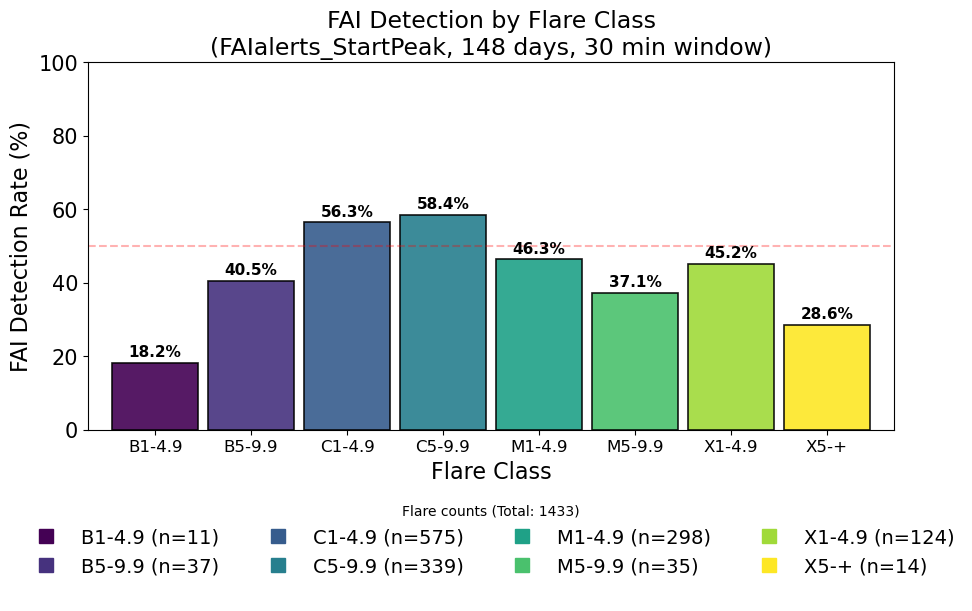

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/FAI_Analysis_FAIalerts_StartPeak_148d_Window30min.png

--- Resumen FAIalerts_StartPeak ---
Total flares: 1433
Flares con FAI: 750 (52.3%)
Métrica: Alertas FAI


In [147]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_StartPeak",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

Usando métrica FAI: FAIalerts_WPeak


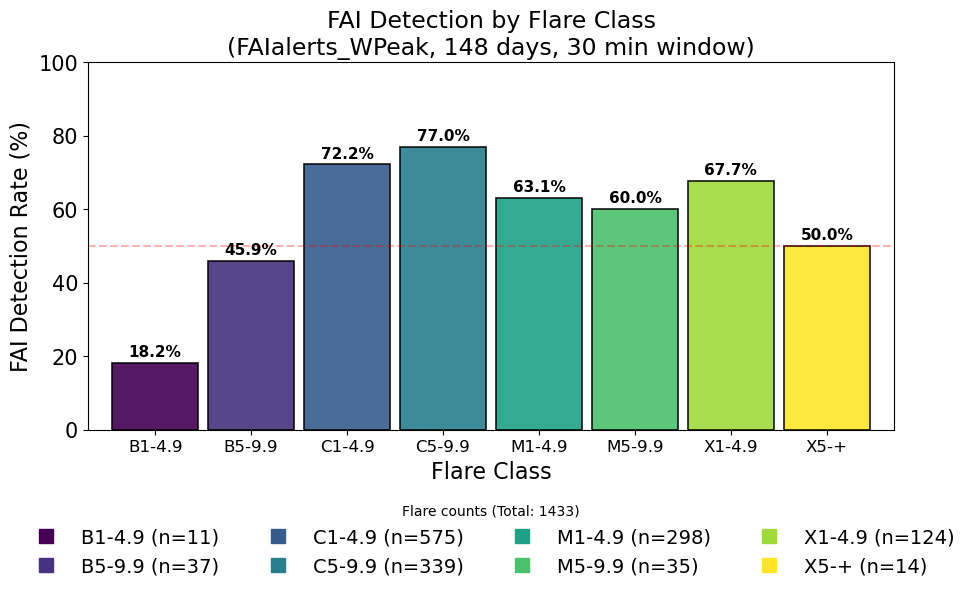

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/FAI_Analysis_FAIalerts_WPeak_148d_Window30min.png

--- Resumen FAIalerts_WPeak ---
Total flares: 1433
Flares con FAI: 995 (69.4%)
Métrica: Alertas FAI


In [146]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_WPeak",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

Usando métrica FAI: FAIalerts_PeakEnd


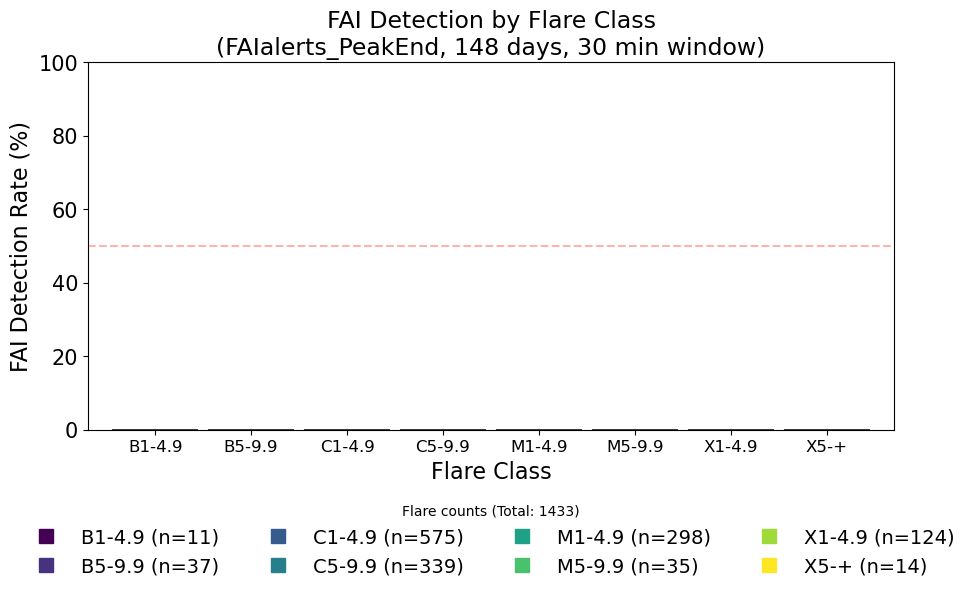

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/FAI_Analysis_FAIalerts_PeakEnd_148d_Window30min.png

--- Resumen FAIalerts_PeakEnd ---
Total flares: 1433
Flares con FAI: 0 (0.0%)
Métrica: Alertas FAI


In [148]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_PeakEnd",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

### Anticipation time

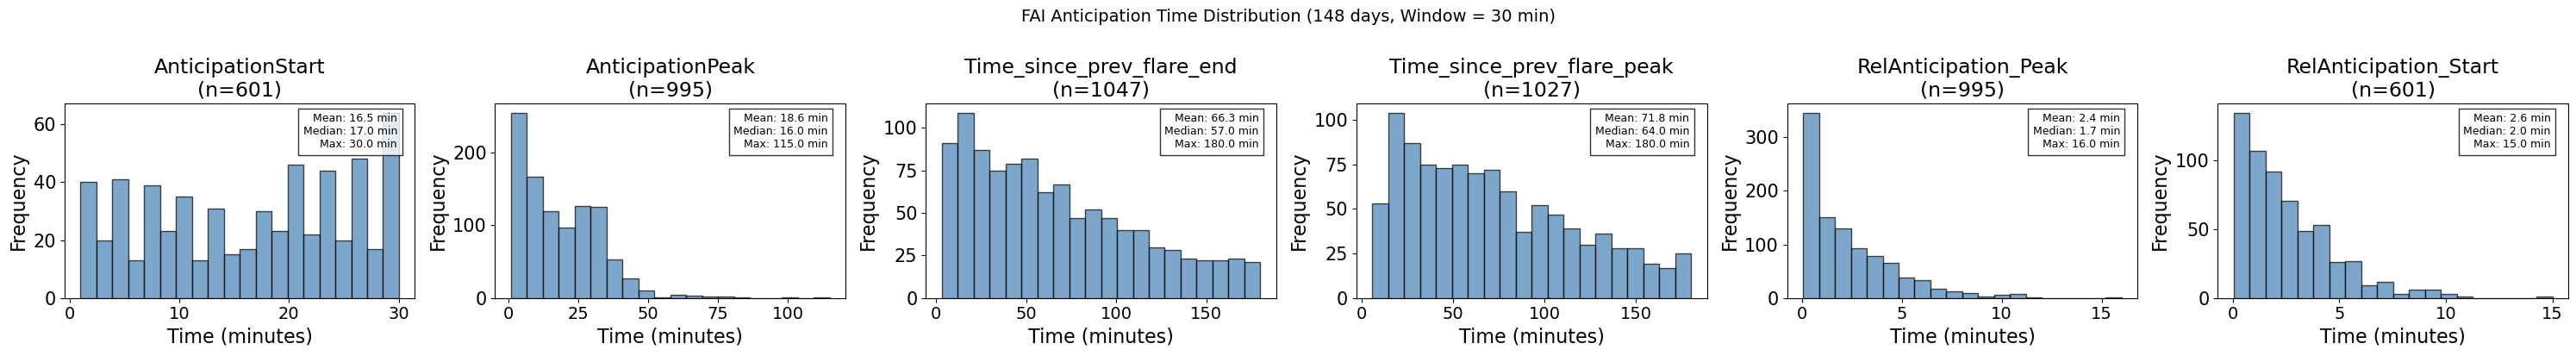

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_Anticipation_Time_Window30min.png


In [125]:
# Uso para tiempos de anticipación:
plot_anticipation_time_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes
)

### Flares con FAI (TP vs FN)

Usando columna FAI: FAIalerts_W


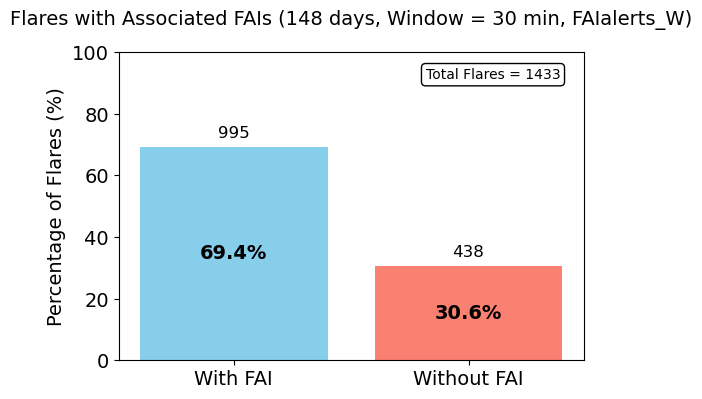

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_Flares_with_FAIs_perc_Window30min.png

--- Estadísticas FAI ---
Total flares analizados: 1433
Flares con FAI: 995 (69.4%)
Flares sin FAI: 438 (30.6%)
Columna FAI utilizada: FAIalerts_W


In [126]:
plot_fai_association(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    fai_column="FAIalerts_W"  # en toda la ventana
)

Columnas FAI encontradas: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'FAIalerts_startEnd', 'Peak_to_lastFAI']


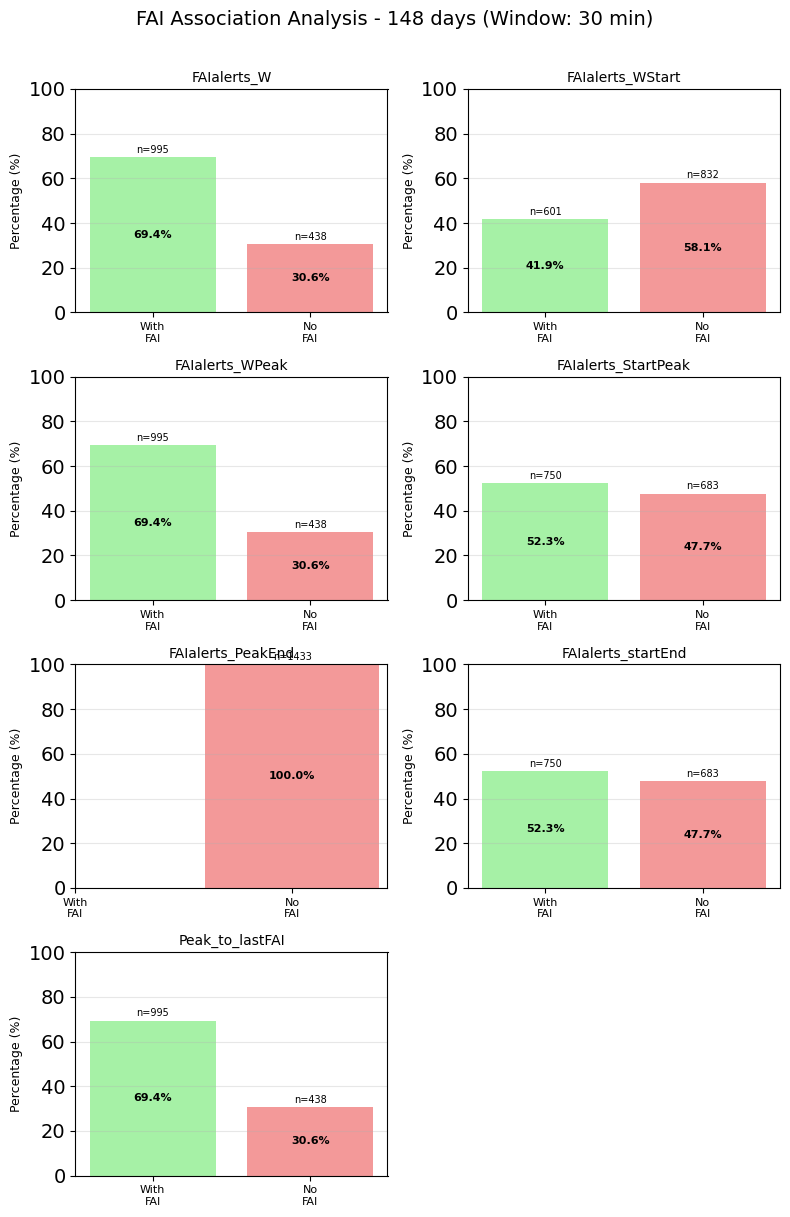

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_Compact_Grid_Window30min.png


In [127]:
# Uso de la versión compacta:
plot_fai_association_compact_grid(
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes
)

### FAI associated to Flare (FP)

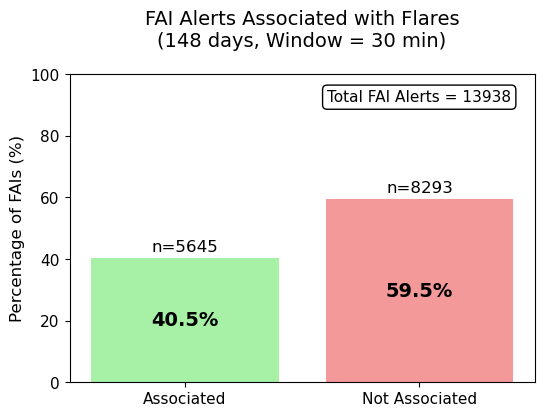

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_associated_Flares_Window30min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 13938
FAIs asociados a flares: 5645 (40.5%)
FAIs no asociados: 8293 (59.5%)
Ventana de asociación: 30 minutos


In [128]:
plot_fai_association_summary(
    df_fai_assoc=df_fai_assoc,
    n_days=new_n,
    window_minutes=window_minutes,
    column="Associated_Flare"
)

Usando columnas: F_Class para clases y Associated_Flare para asociación
Total FAIs en análisis: 13938
Distribución encontrada: {'B1-4.9': 3, 'B5-9.9': 36, 'C1-4.9': 1967, 'C5-9.9': 1481, 'M1-4.9': 1424, 'M5-9.9': 124, 'X1-4.9': 548, 'X5+': 62, 'No flare': 8293}


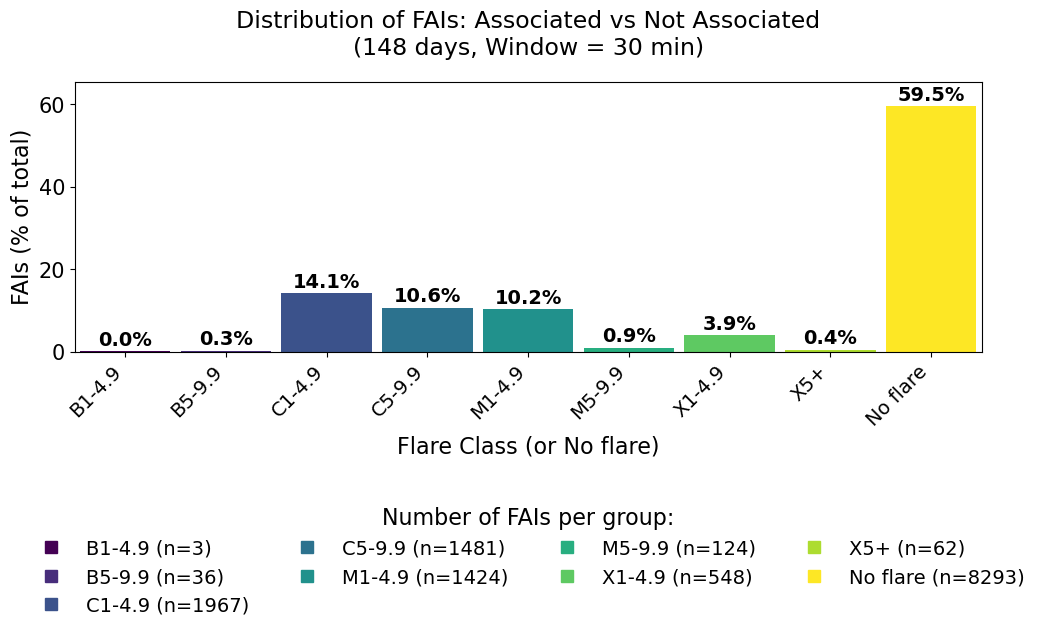

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_Distribution_FAIs_All_Window30min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 13938
FAIs asociados a flares: 5645 (40.5%)
FAIs no asociados: 8293 (59.5%)

Distribución de FAIs asociados por clase:
  C1-4.9: 1967 FAIs (34.8%)
  C5-9.9: 1481 FAIs (26.2%)
  M1-4.9: 1424 FAIs (25.2%)
  X1-4.9: 548 FAIs (9.7%)
  M5-9.9: 124 FAIs (2.2%)
  X5+: 62 FAIs (1.1%)
  B5-9.9: 36 FAIs (0.6%)
  B1-4.9: 3 FAIs (0.1%)


In [129]:
plot_fai_distribution(
    df_fai_assoc=df_fai_assoc,
    n_days=new_n,
    window_minutes=window_minutes,
    class_col="F_Class",
    assoc_col="Associated_Flare",
    group_subclasses=True,
    color_mode="palette:viridis"
)

Using columns: F_Class for classes and Associated_Flare for association
Total FAIs in analysis: 13938
Total flares in analysis: 1433

FAI Detection Rate by Flare Class:
  B: 19/48 flares detected = 39.6%
  C: 676/914 flares detected = 74.0%
  M: 209/333 flares detected = 62.8%
  X: 91/138 flares detected = 65.9%


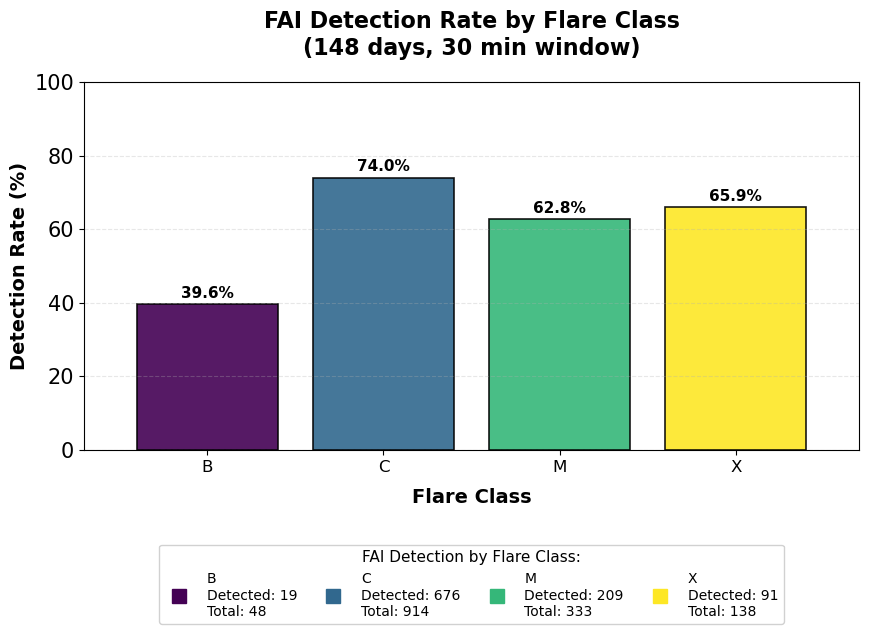

Saved to: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_Detection_Rate_By_Class_W30min_SubClassFalse.png

--- Overall Statistics ---
Total FAIs: 13,938
FAIs associated with flares: 5,645 (40.5%)
FAIs not associated: 8,293 (59.5%)
Total flares: 1,433
Flares detected by FAI: 995 (69.4%)


In [130]:
stats = plot_fai_distribution_by_flare_class(
    df_fai_assoc, 
    df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    class_col="F_Class",
    assoc_col="Associated_Flare",
    group_subclasses=False
)

Using columns: F_Class for classes and Associated_Flare for association
Total FAIs in analysis: 13938
Total flares in analysis: 1433

FAI Detection Rate by Flare Class:
  B1-4.9: 2/11 flares detected = 18.2%
  B5-9.9: 17/37 flares detected = 45.9%
  C1-4.9: 415/575 flares detected = 72.2%
  C5-9.9: 261/339 flares detected = 77.0%
  M1-4.9: 188/298 flares detected = 63.1%
  M5-9.9: 21/35 flares detected = 60.0%
  X1-4.9: 84/124 flares detected = 67.7%
  X5+: 7/14 flares detected = 50.0%


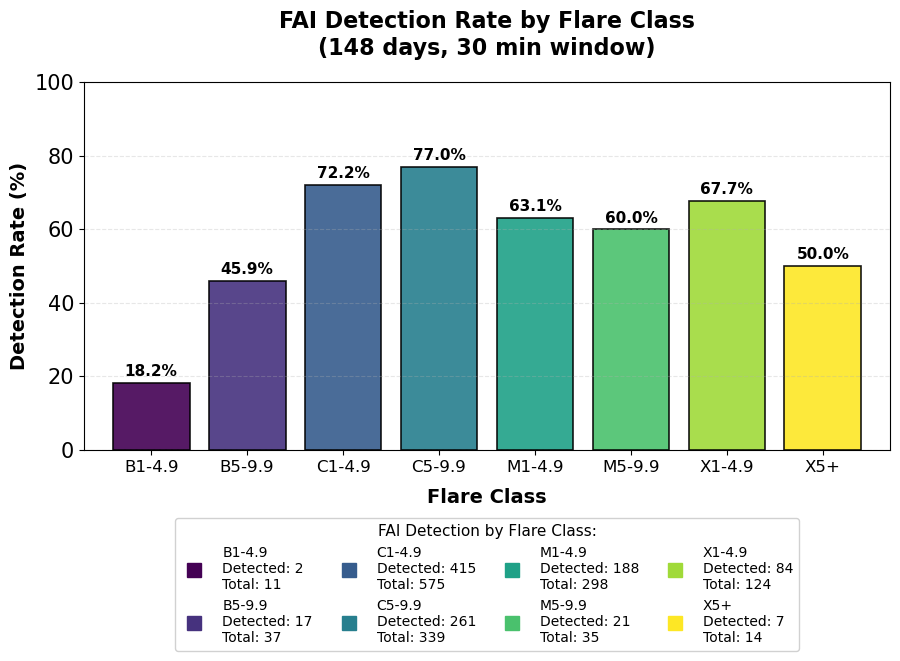

Saved to: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_Detection_Rate_By_Class_W30min_SubClassTrue.png

--- Overall Statistics ---
Total FAIs: 13,938
FAIs associated with flares: 5,645 (40.5%)
FAIs not associated: 8,293 (59.5%)
Total flares: 1,433
Flares detected by FAI: 995 (69.4%)


In [131]:
stats = plot_fai_distribution_by_flare_class(
    df_fai_assoc, 
    df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    class_col="F_Class",
    assoc_col="Associated_Flare",
    group_subclasses=True
)

## GraphicFAI-dual

In [132]:
def plot_fai_flare_dualbar(df_fai_assoc, df_anticipation_time, 
                           n_days, window_minutes,
                           graphics_dir,
                          column_assoc="Associated_Flare", 
                          fai_column="FAIalerts_WPeak"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (con/sin FAI)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columna FAIalerts_W)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica si el flare tiene FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(6, 5.5))

    bars = ["Flares", "FAIs"]
    
    # Parte inferior (asociados)
    ax.bar(bars, [pct_flare_with, pct_fai_assoc],
           color='#6BCB77', label='Associated', alpha=0.9, edgecolor='black')

    # Parte superior (no asociados)
    ax.bar(bars, [pct_flare_without, pct_fai_notassoc],
           bottom=[pct_flare_with, pct_fai_assoc],
           color='#FF6B6B', label='Not Associated', alpha=0.9, edgecolor='black')

    # Etiquetas de porcentaje dentro de cada parte
    for i, (with_pct, without_pct) in enumerate(zip([pct_flare_with, pct_fai_assoc],
                                                    [pct_flare_without, pct_fai_notassoc])):
        # Etiqueta para la parte inferior (asociados)
        if with_pct > 5:
            ax.text(i, with_pct / 2, f"{with_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta para la parte superior (no asociados)
        if without_pct > 5:
            ax.text(i, with_pct + without_pct / 2, f"{without_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association Overview\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda
    legend = ax.legend(title="Association", loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fontsize=11, title_fontsize=12,
                      framealpha=0.9, edgecolor='gray')

    # Recuadro con los totales arriba de la leyenda
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    # Crear el recuadro de totales
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.85, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI (debajo de la leyenda)
    params_text = f"Window:{fai_column}\nMethod:{method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)


    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio al recuadro
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_DualBar_W{window_minutes}min{fai_column}_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False) # transparent = True -> sin fondo, 
                                                                             #  transparent = False -> fondo blanco
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen ---")
    print(f"Total Flares: {total_flare} → {pct_flare_with:.1f}% con FAI, {pct_flare_without:.1f}% sin FAI")
    print(f"Total FAIs: {total_fai} → {pct_fai_assoc:.1f}% asociados, {pct_fai_notassoc:.1f}% no asociados")

def plot_fai_flare_triplebar2(df_fai_assoc, df_anticipation_time, 
                              n_days, window_minutes,
                              graphics_dir,
                            column_assoc="Associated_Flare", 
                            fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (discriminado por ventanas temporales según fai_column)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columnas FAIalerts_WStart, FAIalerts_StartPeak, FAIalerts_PeakEnd)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica qué ventana usar para determinar flares con FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares usando fai_column ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Determinar qué ventanas mostrar según fai_column ---
    if fai_column == "FAIalerts_W":
        # Ventana completa: mostrar todas las categorías
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_only_during_peak_end = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                     (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                                     (df_anticipation_time["FAIalerts_PeakEnd"] > 0)).sum()
        flares_without_fai = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                            (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                            (df_anticipation_time["FAIalerts_PeakEnd"] == 0)).sum()
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_only_during_peak_end, flares_without_fai]
        flare_labels = ['Before Start', 'Start to Peak', 'Peak to End', 'No FAI']
        colors_flares = ['#2E8B57', '#6BCB77', '#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WStart":
        # Solo FAIs antes del Start
        flares_with_fai_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_without_fai_before_start = total_flare - flares_with_fai_before_start
        
        flare_segments = [flares_with_fai_before_start, flares_without_fai_before_start]
        flare_labels = ['FAI Before Start', 'No FAI Before Start']
        colors_flares = ['#2E8B57', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WPeak":
        # FAIs antes del Peak (incluye Before Start + Start to Peak)
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_without_fai_before_peak = total_flare - (flares_before_start + flares_only_during_start_peak)
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_without_fai_before_peak]
        flare_labels = ['Before Start', 'Start to Peak', 'No FAI Before Peak']
        colors_flares = ['#2E8B57', '#6BCB77', '#FF6B6B']
        
    elif fai_column == "FAIalerts_StartPeak":
        # Solo FAIs entre Start y Peak
        flares_with_fai_start_peak = (df_anticipation_time["FAIalerts_StartPeak"] > 0).sum()
        flares_without_fai_start_peak = total_flare - flares_with_fai_start_peak
        
        flare_segments = [flares_with_fai_start_peak, flares_without_fai_start_peak]
        flare_labels = ['FAI Start-Peak', 'No FAI Start-Peak']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_PeakEnd":
        # Solo FAIs entre Peak y End
        flares_with_fai_peak_end = (df_anticipation_time["FAIalerts_PeakEnd"] > 0).sum()
        flares_without_fai_peak_end = total_flare - flares_with_fai_peak_end
        
        flare_segments = [flares_with_fai_peak_end, flares_without_fai_peak_end]
        flare_labels = ['FAI Peak-End', 'No FAI Peak-End']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    else:
        # Por defecto, usar ventana completa
        flares_with_fai = (df_anticipation_time[fai_column] > 0).sum()
        flares_without_fai = total_flare - flares_with_fai
        
        flare_segments = [flares_with_fai, flares_without_fai]
        flare_labels = [f'With {fai_column}', f'Without {fai_column}']
        colors_flares = ['#6BCB77', '#FF6B6B']

    # Calcular porcentajes
    pct_flare_segments = [segment / total_flare * 100 for segment in flare_segments]

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(7, 6))

    bars = ["Flares", "FAIs"]
    
    # Barra de FLARES (segmentos variables según fai_column)
    bottom = 0
    for i, (pct, color, label) in enumerate(zip(pct_flare_segments, colors_flares, flare_labels)):
        ax.bar(bars[0], pct, bottom=bottom, color=color, label=label, alpha=0.9, edgecolor='black')
        # Etiqueta dentro de la barra si el segmento es suficientemente grande
        if pct > 3:
            ax.text(0, bottom + pct/2, f"{pct:.1f}%", 
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        bottom += pct

    # Barra de FAIs (2 segmentos - misma lógica original)
    ax.bar(bars[1], pct_fai_assoc, color='#6BCB77', alpha=0.9, edgecolor='black')
    ax.bar(bars[1], pct_fai_notassoc, bottom=pct_fai_assoc, color='#FF6B6B', alpha=0.9, edgecolor='black')
    
    # Etiquetas para barra de FAIs
    if pct_fai_assoc > 5:
        ax.text(1, pct_fai_assoc / 2, f"{pct_fai_assoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    if pct_fai_notassoc > 5:
        ax.text(1, pct_fai_assoc + pct_fai_notassoc / 2, f"{pct_fai_notassoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association: {fai_column}\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda para flares
    legend_flares = ax.legend(title=f"Flare Categories\n({fai_column})", 
                             loc='center left', bbox_to_anchor=(1.02, 0.6),
                             frameon=True, fontsize=10, title_fontsize=11,
                             framealpha=0.9, edgecolor='gray')

    # Leyenda simple para FAIs
    from matplotlib.patches import Patch
    fai_legend_elements = [
        Patch(facecolor='#6BCB77', label='FAI Associated'),
        Patch(facecolor='#FF6B6B', label='FAI Not Associated')
    ]
    legend_fais = ax.legend(handles=fai_legend_elements, title="FAI Status", 
                           loc='center left', bbox_to_anchor=(1.02, 0.35),
                           frameon=True, fontsize=10, title_fontsize=11,
                           framealpha=0.9, edgecolor='gray')
    
    # Añadir ambas leyendas al gráfico
    ax.add_artist(legend_flares)

    # Recuadro con los totales
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.9, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI
    params_text = f"Window: {fai_column}\nMethod: {method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio a las leyendas
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_TripleBar_{fai_column}_W{window_minutes}min_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print(f"\n--- Resumen para {fai_column} ---")
    print(f"FLARES (Total: {total_flare}):")
    for label, count, pct in zip(flare_labels, flare_segments, pct_flare_segments):
        print(f"  • {label}: {count} ({pct:.1f}%)")
    print(f"FAIs (Total: {total_fai}):")
    print(f"  • Asociados a flares:    {fai_assoc_true} ({pct_fai_assoc:.1f}%)")
    print(f"  • No asociados a flares: {fai_assoc_false} ({pct_fai_notassoc:.1f}%)")

def plot_fai_flare_dualbar_by_class(df_fai_assoc, df_anticipation_time, 
                                   n_days, window_minutes,
                                   graphics_dir,
                                   column_assoc="Associated_Flare", 
                                   fai_column="FAIalerts_WPeak",
                                   class_column="ClassLetter"):
    """
    Genera un gráfico con barras verticales al 100% por clase de flare:
    - Una barra para cada clase de flare (A, B, C, M, X)
    - Cada barra muestra el porcentaje de flares con/sin FAI para esa clase
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columna FAIalerts_W y ClassLetter)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica si el flare tiene FAI
    class_column : str
        Columna que contiene la clase del flare (A, B, C, M, X)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    # --- Preparar datos de Flares por clase ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    # Agrupar por clase de flare
    class_stats = []
    flare_classes = ['A', 'B', 'C', 'M', 'X']
    
    for class_letter in flare_classes:
        class_flares = df_anticipation_time[df_anticipation_time[class_column] == class_letter]
        if len(class_flares) > 0:
            flare_with_fai = class_flares['FAI_bool'].sum()
            flare_without_fai = len(class_flares) - flare_with_fai
            total_flare_class = len(class_flares)
            pct_flare_with = flare_with_fai / total_flare_class * 100
            pct_flare_without = flare_without_fai / total_flare_class * 100
            
            class_stats.append({
                'Class': class_letter,
                'Total_Flares': total_flare_class,
                'With_FAI': flare_with_fai,
                'Without_FAI': flare_without_fai,
                'Pct_With_FAI': pct_flare_with,
                'Pct_Without_FAI': pct_flare_without
            })

    # Crear DataFrame con las estadísticas por clase
    stats_df = pd.DataFrame(class_stats)
    
    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(10, 6))

    bars = stats_df['Class'].tolist()
    pct_with_fai = stats_df['Pct_With_FAI'].tolist()
    pct_without_fai = stats_df['Pct_Without_FAI'].tolist()
    totals = stats_df['Total_Flares'].tolist()

    # Parte inferior (flares con FAI)
    ax.bar(bars, pct_with_fai,
           color='#6BCB77', label='With FAI', alpha=0.9, edgecolor='black')

    # Parte superior (flares sin FAI)
    ax.bar(bars, pct_without_fai,
           bottom=pct_with_fai,
           color='#FF6B6B', label='Without FAI', alpha=0.9, edgecolor='black')

    # Etiquetas de porcentaje dentro de cada parte
    for i, (with_pct, without_pct, total) in enumerate(zip(pct_with_fai, pct_without_fai, totals)):
        # Etiqueta para la parte inferior (con FAI)
        if with_pct > 5:
            ax.text(i, with_pct / 2, f"{with_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta para la parte superior (sin FAI)
        if without_pct > 5:
            ax.text(i, with_pct + without_pct / 2, f"{without_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta con el total debajo de cada barra
        ax.text(i, -6, f"n={total}",
                ha='center', va='top', fontsize=9, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_xlabel("Flare Class", fontsize=12, labelpad=17)  #labelpad=15 espaciar nombre eje X
    ax.set_title(f"FAI Detection by Flare Class\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=14, fontweight='bold')

    # Leyenda
    legend = ax.legend(title="FAI Detection", loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fontsize=11, title_fontsize=12,
                      framealpha=0.9, edgecolor='gray')

    # Recuadro con los totales generales
    total_flares_all = df_anticipation_time[class_column].notna().sum()
    total_with_fai_all = df_anticipation_time['FAI_bool'].sum()
    total_without_fai_all = total_flares_all - total_with_fai_all
    pct_with_fai_all = total_with_fai_all / total_flares_all * 100
    
    total_text = f"Overall Totals:\nTotal Flares: {total_flares_all}\nWith FAI: {total_with_fai_all} ({pct_with_fai_all:.1f}%)\nWithout FAI: {total_without_fai_all} ({100-pct_with_fai_all:.1f}%)"
    
    # Crear el recuadro de totales
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.05, 0.85, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio al recuadro
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    # Guardar figura
    output_name = f"{n_days}d_FAI_Detection_By_Class_W{window_minutes}min_{fai_column}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen por Clase ---")
    for _, row in stats_df.iterrows():
        print(f"Clase {row['Class']}: {row['Total_Flares']} flares → {row['Pct_With_FAI']:.1f}% con FAI, {row['Pct_Without_FAI']:.1f}% sin FAI")
    
    print(f"\n--- Total General ---")
    print(f"Total Flares: {total_flares_all} → {pct_with_fai_all:.1f}% con FAI, {100-pct_with_fai_all:.1f}% sin FAI")

    return stats_df

#

In [133]:
fai_column="FAIalerts_WPeak" # "FAIalerts_W",  Columna en df_anticipation_time que indica si el flare tiene FAI
                        # "FAIalerts_WStart"
                        # "FAIalerts_WPeak"
                        # "FAIalerts_StartPeak"
                        # "FAIalerts_PeakEnd"
                        # "FAIalerts_startEnd"

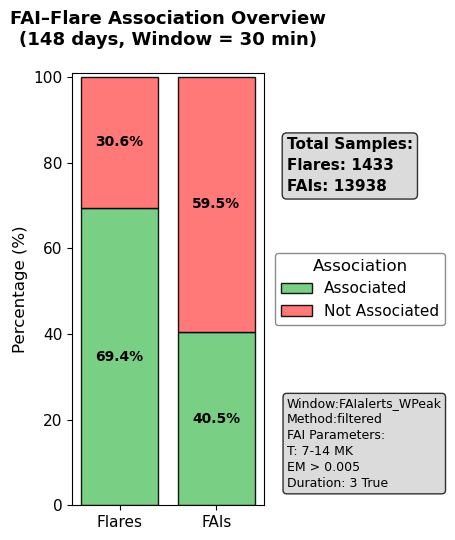

✅ Gráfico guardado en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/filtered148d_FAI_Flare_DualBar_W30minFAIalerts_WPeak_durTrue_3_T7-14_EM0.005.png

--- Resumen ---
Total Flares: 1433 → 69.4% con FAI, 30.6% sin FAI
Total FAIs: 13938 → 40.5% asociados, 59.5% no asociados


In [134]:
plot_fai_flare_dualbar(
    df_fai_assoc=df_fai_assoc,
    df_anticipation_time=df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    graphics_dir=graphics_dir,
    column_assoc="Associated_Flare", 
    fai_column=fai_column)


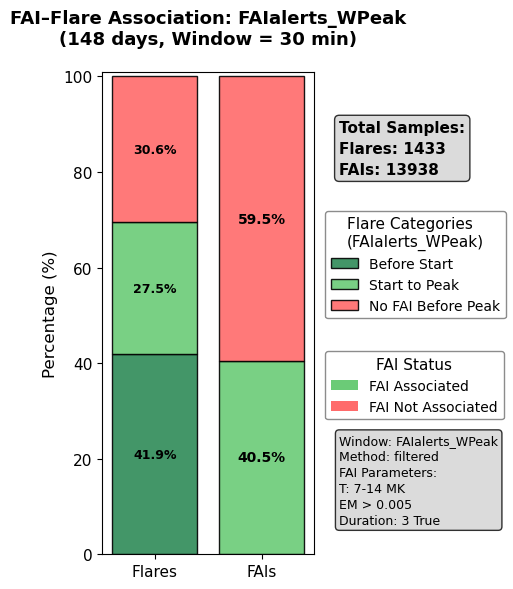

✅ Gráfico guardado en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/filtered148d_FAI_Flare_TripleBar_FAIalerts_WPeak_W30min_durTrue_3_T7-14_EM0.005.png

--- Resumen para FAIalerts_WPeak ---
FLARES (Total: 1433):
  • Before Start: 601 (41.9%)
  • Start to Peak: 394 (27.5%)
  • No FAI Before Peak: 438 (30.6%)
FAIs (Total: 13938):
  • Asociados a flares:    5645 (40.5%)
  • No asociados a flares: 8293 (59.5%)


In [135]:
plot_fai_flare_triplebar2(df_fai_assoc, 
                         df_anticipation_time, 
                         n_days=new_n, 
                         window_minutes=window_minutes,
                         graphics_dir=graphics_dir,
                         column_assoc="Associated_Flare", 
                         fai_column=fai_column)


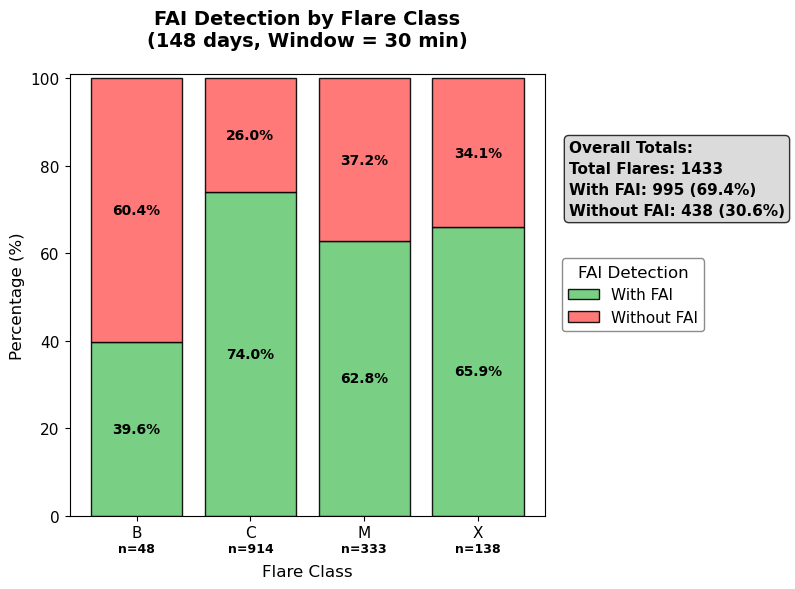

✅ Gráfico guardado en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_FAI_Detection_By_Class_W30min_FAIalerts_WPeak.png

--- Resumen por Clase ---
Clase B: 48 flares → 39.6% con FAI, 60.4% sin FAI
Clase C: 914 flares → 74.0% con FAI, 26.0% sin FAI
Clase M: 333 flares → 62.8% con FAI, 37.2% sin FAI
Clase X: 138 flares → 65.9% con FAI, 34.1% sin FAI

--- Total General ---
Total Flares: 1433 → 69.4% con FAI, 30.6% sin FAI


In [136]:
# Llamar la función
stats = plot_fai_flare_dualbar_by_class(
    df_fai_assoc, 
    df_anticipation_time,
    n_days=new_n,
    window_minutes=window_minutes,
    graphics_dir=graphics_dir,
    fai_column="FAIalerts_WPeak",
    class_column="ClassLetter"
)

## Statistics

In [137]:
def create_fai_statistics_table(df_anticipation_time, analysis_dir, output_filename=None):
    """
    Create comprehensive FAI statistics table by flare class and save to CSV.
    
    Parameters:
    - df_anticipation_time: DataFrame with FAI data
    - output_filename: Name for output CSV file (optional)
    
    Returns:
    - DataFrame with FAI statistics
    """
    
    # Create summary by ClassLetter
    stats_by_class = df_anticipation_time.groupby('ClassLetter').agg(
        Total_Flares=('ClassLetter', 'count'),
        With_FAI=('FAIalerts_W', lambda x: (x != 0).sum()),
        Without_FAI=('FAIalerts_W', lambda x: (x == 0).sum())
    ).reset_index()
    
    # Calculate percentages
    stats_by_class['Percent_With_FAI'] = (stats_by_class['With_FAI'] / stats_by_class['Total_Flares'] * 100).round(2)
    stats_by_class['Percent_Without_FAI'] = (stats_by_class['Without_FAI'] / stats_by_class['Total_Flares'] * 100).round(2)
    
    # Order by flare class (A, B, C, M, X)
    class_order = ['A', 'B', 'C', 'M', 'X']
    stats_by_class['ClassLetter'] = pd.Categorical(stats_by_class['ClassLetter'], 
                                                  categories=class_order, ordered=True)
    stats_by_class = stats_by_class.sort_values('ClassLetter')
    
    # Calculate totals for all classes
    total_flares = len(df_anticipation_time)
    total_with_fai = (df_anticipation_time['FAIalerts_W'] != 0).sum()
    total_without_fai = (df_anticipation_time['FAIalerts_W'] == 0).sum()
    percent_with_fai = (total_with_fai / total_flares * 100).round(2)
    percent_without_fai = (total_without_fai / total_flares * 100).round(2)
    
    # Create total row
    total_row = pd.DataFrame({
        'ClassLetter': ['TOTAL'],
        'Total_Flares': [total_flares],
        'With_FAI': [total_with_fai],
        'Without_FAI': [total_without_fai],
        'Percent_With_FAI': [percent_with_fai],
        'Percent_Without_FAI': [percent_without_fai]
    })
    
    # Combine class statistics with total row
    final_stats = pd.concat([stats_by_class, total_row], ignore_index=True)
    
    # Add additional statistics
    final_stats['FAI_Rate'] = final_stats['Percent_With_FAI']
    final_stats['Detection_Efficiency'] = final_stats['Percent_With_FAI']
    
    # Reorder columns for better readability
    column_order = [
        'ClassLetter', 
        'Total_Flares', 
        'With_FAI', 
        'Without_FAI', 
        'Percent_With_FAI', 
        'Percent_Without_FAI',
        'FAI_Rate',
        'Detection_Efficiency'
    ]
    final_stats = final_stats[column_order]
    
    # Display the table
    print("FAI Statistics by Flare Class")
    print("=" * 90)
    print(final_stats.to_string(index=False))
    print("=" * 90)
    
    # Print summary
    print(f"\nSummary Statistics:")
    print(f"Total flares analyzed: {total_flares}")
    print(f"Flares with FAI alerts: {total_with_fai} ({percent_with_fai}%)")
    print(f"Flares without FAI alerts: {total_without_fai} ({percent_without_fai}%)")
    
    # Save to CSV if filename provided
    if output_filename:
        # Ensure it has .csv extension
        if not output_filename.endswith('.csv'):
            output_filename += '.csv'
        
        output_path = os.path.join(analysis_dir, output_filename)
        final_stats.to_csv(output_path, index=False)
        print(f"\nStatistics table saved to: {output_path}")
    
    return final_stats

# Usage example:
# stats_df = create_fai_statistics_table(df_anticipation_time, "FAI_statistics_summary")

def create_detailed_fai_statistics(df_anticipation_time, analysis_dir, output_filename=None):
    """
    Create detailed FAI statistics with additional metrics.
    
    Parameters:
    - df_anticipation_time: DataFrame with FAI data
    - output_filename: Name for output CSV file (optional)
    
    Returns:
    - DataFrame with detailed FAI statistics
    """
    
    # Define flare class order
    class_order = ['A', 'B', 'C', 'M', 'X']
    
    # Create basic statistics
    basic_stats = df_anticipation_time.groupby('ClassLetter').agg(
        Total_Flares=('ClassLetter', 'count'),
        With_FAI=('FAIalerts_W', lambda x: (x != 0).sum()),
        Without_FAI=('FAIalerts_W', lambda x: (x == 0).sum()),
        Max_FAI_Alerts=('FAIalerts_W', 'max'),
        Min_FAI_Alerts=('FAIalerts_W', 'min')
    ).reset_index()
    
    # Calculate percentages and rates
    basic_stats['Detection_Rate_Percent'] = (basic_stats['With_FAI'] / basic_stats['Total_Flares'] * 100).round(2)
    basic_stats['FalseNegatives_Percent'] = (basic_stats['Without_FAI'] / basic_stats['Total_Flares'] * 100).round(2)
    
    # Order by flare class
    basic_stats['ClassLetter'] = pd.Categorical(basic_stats['ClassLetter'], 
                                               categories=class_order, ordered=True)
    basic_stats = basic_stats.sort_values('ClassLetter')
    
    # Calculate totals
    total_flares = len(df_anticipation_time)
    total_with_fai = (df_anticipation_time['FAIalerts_W'] != 0).sum()
    total_without_fai = (df_anticipation_time['FAIalerts_W'] == 0).sum()
    max_fai_all = df_anticipation_time['FAIalerts_W'].max()
    min_fai_all = df_anticipation_time['FAIalerts_W'].min()
    
    # Create total row
    total_row = pd.DataFrame({
        'ClassLetter': ['TOTAL'],
        'Total_Flares': [total_flares],
        'With_FAI': [total_with_fai],
        'Without_FAI': [total_without_fai],
        'Max_FAI_Alerts': [max_fai_all],
        'Min_FAI_Alerts': [min_fai_all],
        'Detection_Rate_Percent': [(total_with_fai / total_flares * 100).round(2)],
        'FalseNegatives_Percent': [(total_without_fai / total_flares * 100).round(2)]
    })
    
    # Combine all data
    detailed_stats = pd.concat([basic_stats, total_row], ignore_index=True)
    
    # Calculate additional metrics
    detailed_stats['FAI_Efficiency'] = detailed_stats['Detection_Rate_Percent']
    detailed_stats['Success_Ratio'] = detailed_stats['Detection_Rate_Percent'] / 100
    
    # Display results
    print("DETAILED FAI STATISTICS BY FLARE CLASS")
    print("=" * 120)
    print(detailed_stats.to_string(index=False, float_format='%.2f'))
    print("=" * 120)
    
    # Print key insights
    print(f"\nKEY INSIGHTS:")
    print(f"Overall detection rate: {total_with_fai/total_flares*100:.1f}%")
    print(f"Most FAI alerts in a single flare: {max_fai_all}")
    
    # Save to CSV if requested
    if output_filename:
        if not output_filename.endswith('.csv'):
            output_filename += '.csv'
        output_path = os.path.join(analysis_dir, output_filename)
        detailed_stats.to_csv(output_path, index=False)
        print(f"\nDetailed statistics saved to: {output_path}")
    
    return detailed_stats

# Usage examples:
# stats_simple = create_fai_statistics_table(df_anticipation_time, "FAI_basic_stats")
# stats_detailed = create_detailed_fai_statistics(df_anticipation_time, "FAI_detailed_stats")

In [138]:
stats_simple = create_fai_statistics_table(df_anticipation_time, analysis_dir=analysis_esp,
                                           output_filename="FAI_basic_stats")

FAI Statistics by Flare Class
ClassLetter  Total_Flares  With_FAI  Without_FAI  Percent_With_FAI  Percent_Without_FAI  FAI_Rate  Detection_Efficiency
          B            48        19           29             39.58                60.42     39.58                 39.58
          C           914       676          238             73.96                26.04     73.96                 73.96
          M           333       209          124             62.76                37.24     62.76                 62.76
          X           138        91           47             65.94                34.06     65.94                 65.94
      TOTAL          1433       995          438             69.43                30.57     69.43                 69.43

Summary Statistics:
Total flares analyzed: 1433
Flares with FAI alerts: 995 (69.43%)
Flares without FAI alerts: 438 (30.57%)

Statistics table saved to: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/FAI_basic_stats.csv


In [139]:
stats_detailed = create_detailed_fai_statistics(df_anticipation_time, analysis_dir=analysis_esp, 
                                                output_filename="FAI_detailed_stats")

DETAILED FAI STATISTICS BY FLARE CLASS
ClassLetter  Total_Flares  With_FAI  Without_FAI  Max_FAI_Alerts  Min_FAI_Alerts  Detection_Rate_Percent  FalseNegatives_Percent  FAI_Efficiency  Success_Ratio
          B            48        19           29               8               0                   39.58                   60.42           39.58           0.40
          C           914       676          238              32               0                   73.96                   26.04           73.96           0.74
          M           333       209          124              36               0                   62.76                   37.24           62.76           0.63
          X           138        91           47              18               0                   65.94                   34.06           65.94           0.66
      TOTAL          1433       995          438              36               0                   69.43                   30.57           69.43           0.69

